import library

In [186]:
import numpy as np
import pandas as pd
import collections
from IPython import display
from matplotlib import pyplot as plt
import sklearn
import sklearn.manifold
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()

Read the data. Below is the first 5 rows of the data. The column 'behavior' can have 4 value {'pv','fav','cart','buy'} corresponding for 4 actions visit, favour, add to cart and buy.

In [187]:
ratings = pd.read_csv("UserBehavior.csv",dtype={'user_id':int, 'item_id':int, 'category_id':int, 'behavior':str, 'timestamp':np.int64})
print(ratings.head())
ratings.describe()

   user_id  item_id  category_id behavior   timestamp
0        1  2268318      2520377       pv  1511544070
1        1  2333346      2520771       pv  1511561733
2        1  2576651       149192       pv  1511572885
3        1  3830808      4181361       pv  1511593493
4        1  4365585      2520377       pv  1511596146
pv      89.872
cart     5.596
fav      2.422
buy      2.110
Name: behavior, dtype: float64


Calculate percentage of each behavior

In [188]:
behavior_counts = ratings['behavior'].value_counts()
behavior_percents = behavior_counts / len(ratings) * 100
print(behavior_percents)

pv      89.872
cart     5.596
fav      2.422
buy      2.110
Name: behavior, dtype: float64


I encode each type of behavior to a specific real number in  [0;1] and store the score in column 'score'.

In [189]:
# Convert behavior types to scores
behavior_scores = {'pv': 0.02, 'fav': 0.5, 'cart': 0.3, 'buy': 0.9}
ratings['score'] = ratings['behavior'].map(behavior_scores)
ratings.head()

,user_id,item_id,category_id,behavior,timestamp,score
0,1,2268318,2520377,pv,1511544070,0.02
1,1,2333346,2520771,pv,1511561733,0.02
2,1,2576651,149192,pv,1511572885,0.02
3,1,3830808,4181361,pv,1511593493,0.02
4,1,4365585,2520377,pv,1511596146,0.02


In [190]:
ratings = ratings.groupby(['user_id', 'item_id'])['score'].sum().reset_index()
ratings[1:40]

,user_id,item_id,score
1,1,79715,0.02
2,1,230380,0.02
3,1,266784,0.04
4,1,271696,0.02
5,1,568695,0.02
6,1,818610,0.02
7,1,929177,0.02
8,1,1305059,0.02
9,1,1323189,0.02
10,1,1338525,0.02


Create a mapping from real user_id and item_id to consecutive_user_id and consecutive_item_id (1....num users/items)

In [191]:
#`ratings` is a pandas dataframe with columns 'user_id', 'item_id', and 'score'
user_ids = ratings['user_id'].unique()
item_ids = ratings['item_id'].unique()

# Create a mapping of original IDs to consecutive IDs for users and items
user_id_map = pd.Series(np.arange(len(user_ids)), index=user_ids)
item_id_map = pd.Series(np.arange(len(item_ids)), index=item_ids)

# Map the original user and item IDs to consecutive IDs
ratings['consecutive_user_id'] = user_id_map[ratings['user_id']].values
ratings['consecutive_item_id'] = item_id_map[ratings['item_id']].values
ratings


,user_id,item_id,score,consecutive_user_id,consecutive_item_id
0,1,46259,0.04,0,0
1,1,79715,0.02,0,1
2,1,230380,0.02,0,2
3,1,266784,0.04,0,3
4,1,271696,0.02,0,4
...,...,...,...,...,...
37841,1002147,4732007,0.02,471,34318
37842,1002147,4988375,0.02,471,34319
37843,1002147,5023654,0.02,471,34320
37844,1002147,5040478,0.02,471,34321


Create user-item matrix

In [192]:
# Sum up all scores of a user
user_scores = ratings.groupby(['consecutive_user_id', 'consecutive_item_id'])['score'].sum()
# Create a user-item matrix
user_item_matrix = user_scores.unstack()
num_users, num_items = user_item_matrix.shape
num_users, num_items
user_item_matrix
user_item_matrix.shape

(472, 34323)

In [204]:
#calculate percentage of non-nan values in user-item matrix
num_non_nan = np.count_nonzero(~np.isnan(user_item_matrix))
num_non_nan / (num_users * num_items) * 100

0.2336107082417927

In [193]:
def split_matrix(matrix, test_ratio = 0.2):
    num_rows, num_cols = matrix.shape
    train = np.zeros((num_rows, num_cols))
    test = np.zeros((num_rows, num_cols))
    for i in range(num_cols):
        #find indices of non-zero elements
        indices = np.where(~np.isnan(matrix[:,i]))[0]
        if len(indices) < 3:
            continue
        test_idx = np.random.choice(indices, 2, replace=False)
        test[test_idx, i] = matrix[test_idx, i]
        train[:, i] = matrix[:, i]
        train[test_idx, i] = 0
    return train, test

In [196]:
def build_rating_sparse_tensor(matrix):
    """
    Args:
        matrix: A 2D numpy array representing the user-item matrix.
        
    Returns:
        a tf.SparseTensor representing the ratings matrix.
    """
    # Find the indices of the non-zero elements in the matrix
    row_indices, col_indices = np.nonzero(matrix)
    
    # Get the non-zero values in the matrix
    values = matrix[row_indices, col_indices]
    
    # Compute the number of users and items in the matrix
    num_users = matrix.shape[0]
    num_items = matrix.shape[1]
    
    # Create a SparseTensorValue object
    sparse_tensor_value = tf.SparseTensorValue(
        indices=np.array([row_indices, col_indices]).T,
        values=values,
        dense_shape=[num_users, num_items]
    )
    
    
    return sparse_tensor_value

In [197]:
def sparse_mean_square_error(r,u,v):
  """
  Args:
    r: A SparseTensor rating matrix, of dense_shape [N, M]
    u: A dense Tensor U such that U_i is the embedding of user i.
    v: A dense Tensor V such that V_j is the embedding of movie j.
  Returns:
    A scalar Tensor representing the MSE between the true ratings and the
      model's predictions.
  """
  # Compute the predicted tensor
  uv = tf.matmul(u, v, transpose_b=True)
  
  # Get the indices and values of the non-zero elements in r
  indices = r.indices
  values = r.values
  
  # Extract the corresponding elements from the predicted tensor
  pred_values = tf.gather_nd(uv, indices)
  
  # Compute the mean squared error of the non-zero elements
  mse = tf.reduce_mean(tf.square(values - pred_values))
  
  # Compute the root mean squared error
  rmse = tf.sqrt(mse)
  
  return rmse

In [198]:
# @title CFModel helper class (run this cell)
class CFModel(object):
  """Simple class that represents a collaborative filtering model"""
  def __init__(self, embedding_vars, loss, metrics=None):
    """Initializes a CFModel.
    Args:
      embedding_vars: A dictionary of tf.Variables.
      loss: A float Tensor. The loss to optimize.
      metrics: optional list of dictionaries of Tensors. The metrics in each
        dictionary will be plotted in a separate figure during training.
    """
    self._embedding_vars = embedding_vars
    self._loss = loss
    self._metrics = metrics
    self._embeddings = {k: None for k in embedding_vars}
    self._session = None

  @property
  def embeddings(self):
    """The embeddings dictionary."""
    return self._embeddings

  def train(self, num_iterations=30, learning_rate=1.0, plot_results=True,
            optimizer=tf.train.GradientDescentOptimizer):
    """Trains the model.
    Args:
      iterations: number of iterations to run.
      learning_rate: optimizer learning rate.
      plot_results: whether to plot the results at the end of training.
      optimizer: the optimizer to use. Default to GradientDescentOptimizer.
    Returns:
      The metrics dictionary evaluated at the last iteration.
    """
    with self._loss.graph.as_default():
      opt = optimizer(learning_rate)
      train_op = opt.minimize(self._loss)
      local_init_op = tf.group(
          tf.variables_initializer(opt.variables()),
          tf.local_variables_initializer())
      if self._session is None:
        self._session = tf.Session()
        with self._session.as_default():
          self._session.run(tf.global_variables_initializer())
          self._session.run(tf.tables_initializer())
          tf.train.start_queue_runners()

    with self._session.as_default():
      local_init_op.run()
      iterations = []
      metrics = self._metrics or ({},)
      metrics_vals = [collections.defaultdict(list) for _ in self._metrics]

      # Train and append results.
      for i in range(num_iterations + 1):
        _, results = self._session.run((train_op, metrics))
        if (i % 10 == 0) or i == num_iterations:
          print("\r iteration %d: " % i + ", ".join(
                ["%s=%f" % (k, v) for r in results for k, v in r.items()]),
                end='')
          iterations.append(i)
          for metric_val, result in zip(metrics_vals, results):
            for k, v in result.items():
              metric_val[k].append(v)

      for k, v in self._embedding_vars.items():
        self._embeddings[k] = v.eval()

      if plot_results:
        # Plot the metrics.
        num_subplots = len(metrics)+1
        fig = plt.figure()
        fig.set_size_inches(num_subplots*10, 8)
        for i, metric_vals in enumerate(metrics_vals):
          ax = fig.add_subplot(1, num_subplots, i+1)
          for k, v in metric_vals.items():
            ax.plot(iterations, v, label=k)
          ax.set_xlim([1, num_iterations])
          ax.legend()
      return results

In [199]:
#@title Solution
def build_model(ratings, embedding_dim=20, init_stddev=1.):
  """
  Args:
    ratings: a DataFrame of the ratings
    embedding_dim: the dimension of the embedding vectors.
    init_stddev: float, the standard deviation of the random initial embeddings.
  Returns:
    model: a CFModel.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_matrix(ratings.values)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  # Initialize the embeddings using a normal distribution.
  U = tf.Variable(tf.random_normal(
      [A_train.dense_shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [A_train.dense_shape[1], embedding_dim], stddev=init_stddev))
  train_loss = sparse_mean_square_error(A_train, U, V)
  test_loss = sparse_mean_square_error(A_test, U, V)
  metrics = {
      'train_mse': train_loss,
      'test_mse': test_loss
  }
  embeddings = {
      "user_id": U,
      "item_id": V
  }
  return CFModel(embeddings, train_loss, [metrics])

In [200]:
def gravity(U, V):
  """Creates a gravity loss given two embedding matrices."""
  return 1. / (U.shape[0]*V.shape[0]) * tf.reduce_sum(
      tf.matmul(U, U, transpose_a=True) * tf.matmul(V, V, transpose_a=True))

def build_regularized_model(
    ratings, embedding_dim=3, regularization_coeff=.1, gravity_coeff=1.,
    init_stddev=0.1):
  """
  Args:
    ratings: the DataFrame of ratings.
    embedding_dim: The dimension of the embedding space.
    regularization_coeff: The regularization coefficient lambda.
    gravity_coeff: The gravity regularization coefficient lambda_g.
  Returns:
    A CFModel object that uses a regularized loss.
  """
  # Split the ratings DataFrame into train and test.
  train_ratings, test_ratings = split_matrix(ratings.values)
  # SparseTensor representation of the train and test datasets.
  A_train = build_rating_sparse_tensor(train_ratings)
  A_test = build_rating_sparse_tensor(test_ratings)
  U = tf.Variable(tf.random_normal(
      [ratings.shape[0], embedding_dim], stddev=init_stddev))
  V = tf.Variable(tf.random_normal(
      [ratings.shape[1], embedding_dim], stddev=init_stddev))

  error_train = sparse_mean_square_error(A_train, U, V)
  error_test = sparse_mean_square_error(A_test, U, V)
  gravity_loss = gravity_coeff * gravity(U, V)
  regularization_loss = regularization_coeff * (
      tf.reduce_sum(U*U)/U.shape[0] + tf.reduce_sum(V*V)/V.shape[0])
  total_loss = error_train + regularization_loss + gravity_loss
  losses = {
      'train_mse_error_observed': error_train,
      'test_mse_error_observed': error_test,
  }
  loss_components = {
      'observed_loss': error_train,
      'regularization_loss': regularization_loss,
      'gravity_loss': gravity_loss,
  }
  embeddings = {"user_id": U, "item_id": V}

  return CFModel(embeddings, total_loss, [losses, loss_components])

 iteration 150: train_mse=0.353476, test_mse=0.486590

[{'train_mse': 0.3534763, 'test_mse': 0.48658967}]

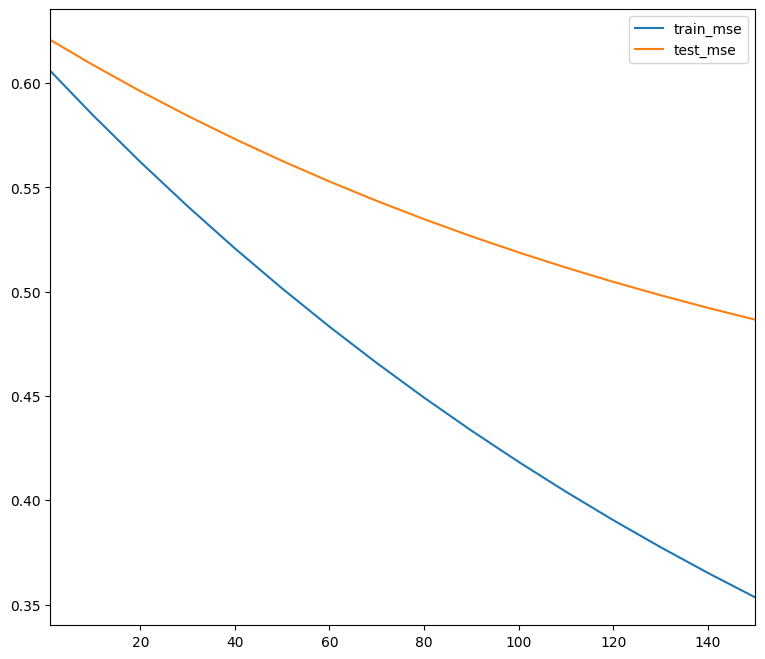

In [201]:
model = build_model(user_item_matrix.fillna(0), embedding_dim=40, init_stddev=0.3)
model.train(num_iterations=150, learning_rate=5.)

 iteration 150: train_mse_error_observed=0.278829, test_mse_error_observed=0.361590, observed_loss=0.278829, regularization_loss=0.471790, gravity_loss=0.010339

[{'train_mse_error_observed': 0.27882928,
  'test_mse_error_observed': 0.36158958},
 {'observed_loss': 0.27882928,
  'regularization_loss': 0.4717895,
  'gravity_loss': 0.010339204}]

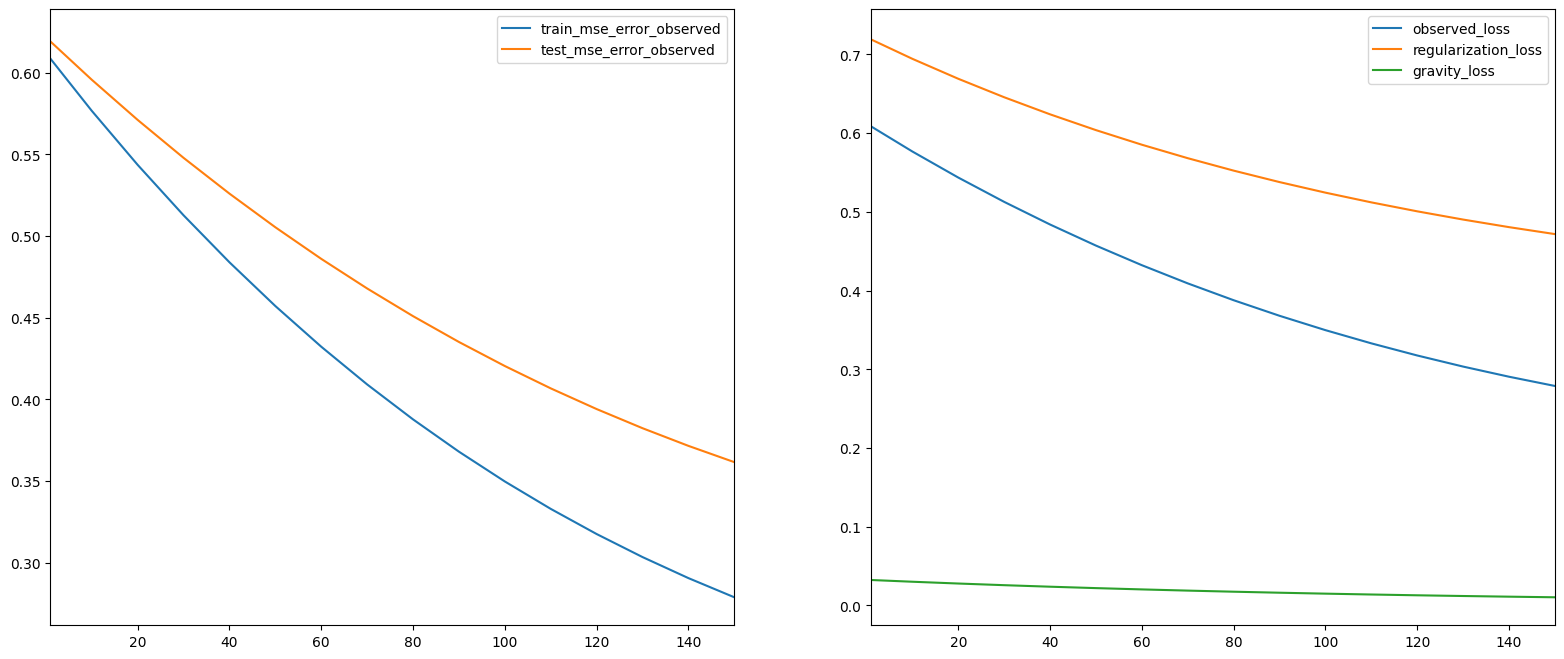

In [202]:
reg_model = build_regularized_model(
    user_item_matrix.fillna(0), regularization_coeff=0.1, gravity_coeff=0.1, embedding_dim=40,
    init_stddev=.3)
reg_model.train(num_iterations=150, learning_rate=5.)

d:\setting app\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
d:\setting app\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


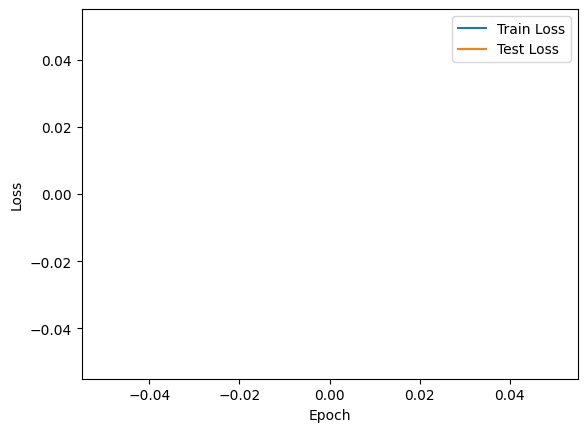

In [203]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
def cl_user_based_model(r, method = 'cosine', k = 5):
    train, test = split_matrix(r.values)
    # Calculate similarity matrix
    # Calculate similarity matrix
    if method == 'cosine':
        sim_matrix = cosine_similarity(train)
    elif method == 'pearson':
        sim_matrix = np.zeros((train.shape[0], train.shape[0]))
        for i in range(train.shape[0]):
            for j in range(train.shape[0]):
                if i == j:
                    sim_matrix[i,j] = 1
                else:
                    mask = np.logical_and(train[i] != 0, train[j] != 0)
                    if np.sum(mask) > 0:
                        sim_matrix[i,j] = pearsonr(train[i,mask], train[j,mask])[0]
                    else:
                        sim_matrix[i,j] = 0
    else:
        raise ValueError("Invalid method. Only 'cosine' and 'pearson' are supported.")

    # Sort similarity matrix and get top-k similar users for each user
    top_k_users = np.argsort(sim_matrix, axis=1)[:,-k:]

    # Predict ratings for test set
    pred = np.zeros(test.shape)
    for i in range(test.shape[0]):
        for j in range(test.shape[1]):
            if test[i,j] != 0:
                pred_ratings = train[top_k_users[i], j]
                nonzero_indices = np.nonzero(pred_ratings)
                if len(nonzero_indices[0]) > 0:
                    pred[i,j] = np.mean(pred_ratings[nonzero_indices])
                else:
                    pred[i,j] = np.mean(train[:,j][train[:,j] != 0])

    # Calculate train and test loss
    train_loss = np.sum(np.square(train - pred) * (train != 0))
    test_loss = np.sum(np.square(test - pred) * (test != 0))

    # Plot train and test loss
    epochs = [0]
    train_losses = [train_loss]
    test_losses = [test_loss]

    for epoch in range(1, 11):
        # Sort similarity matrix and get top-k similar users for each user
        top_k_users = np.argsort(sim_matrix, axis=1)[:,-k:]

        # Predict ratings for test set
        pred = np.zeros(test.shape)
        for i in range(test.shape[0]):
            for j in range(test.shape[1]):
                if test[i,j] != 0:
                    pred_ratings = train[top_k_users[i], j]
                    nonzero_indices = np.nonzero(pred_ratings)
                    if len(nonzero_indices[0]) > 0:
                        pred[i,j] = np.mean(pred_ratings[nonzero_indices])
                    else:
                        pred[i,j] = np.mean(train[:,j][train[:,j] != 0])

        # Calculate train and test loss
        train_loss = np.sum(np.square(train - pred) * (train != 0))
        test_loss = np.sum(np.square(test - pred) * (test != 0))

        epochs.append(epoch)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, test_losses, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    return pred
p = cl_user_based_model(user_item_matrix.fillna(0), method = 'cosine')